# Libraries

In [1]:
import abc
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
from typing import List, Tuple

# Aufgabe 1

## Installieren der MNIST-Datasets

In [2]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 11.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 338kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.59MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.53MB/s]


# Aufgabe 3

## Linear Layer

In [4]:
class LinearLayer:
    def __init__(self, in_features: int, out_features: int, bias: bool = True, learning_rate: float = 0.01):
        self.in_features = in_features
        self.out_features = out_features
        self.bias = bias
        self.learning_rate = learning_rate

        # Xavier initialization works better for this task
        self.weights = np.random.uniform(
            -np.sqrt(6.0 / (in_features + out_features)),
            np.sqrt(6.0 / (in_features + out_features)),
            size=(out_features, in_features)
        )

        # Initialize bias to small values, not zeros
        self.bias_term = np.random.uniform(-0.01, 0.01, size=out_features) if bias else None

        # Gradients
        self.grad_weights = None
        self.grad_bias = None
        self.input_cache = None # Für den Backward-Pass merken wir uns den Input

    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Führt die lineare Transformation y = xW^T + b durch.
        :param x: Input-Matrix (batch_size x in_features)
        :return: Transformierte Matrix (batch_size x out_features)
        """
        # Make sure input is 2D
        if len(x.shape) == 1:
            x = x.reshape(1, -1)

        self.input_cache = x
        y = np.dot(x, self.weights.T)
        if self.bias:
            y += self.bias_term
        return y


    def backward(self, grad_output: np.ndarray) -> np.ndarray:
        # Ensure inputs are properly shaped
        if len(grad_output.shape) == 1:
            grad_output = grad_output.reshape(1, -1)
        if len(self.input_cache.shape) == 1:
            self.input_cache = self.input_cache.reshape(1, -1)

        batch_size = grad_output.shape[0]

        # Correctly compute weight gradients
        self.grad_weights = np.dot(grad_output.T, self.input_cache) / batch_size

        # Clip gradients at a higher threshold to allow learning
        grad_clip_value = 5.0  # Increased from 1.0
        self.grad_weights = np.clip(self.grad_weights, -grad_clip_value, grad_clip_value)

        if self.bias:
            self.grad_bias = np.mean(grad_output, axis=0)
            self.grad_bias = np.clip(self.grad_bias, -grad_clip_value, grad_clip_value)

        # Gradient for previous layer
        grad_input = np.dot(grad_output, self.weights)

        return grad_input


    def update_parameters(self) -> None:
        """
        Führt das Update der Gewichte und des Bias durch (Gradient Descent).
        """
        self.weights -= self.learning_rate * self.grad_weights
        if self.bias:
            self.bias_term -= self.learning_rate * self.grad_bias

## Activation Functions

In [5]:
class ActivationFunction(abc.ABC):
    @abc.abstractmethod
    def activate(self, x: np.ndarray) -> np.ndarray:
        ...

    @abc.abstractmethod
    def derivative(self, x: np.ndarray) -> np.ndarray:
        pass

class ReLU(ActivationFunction):
    def __init__(self):
        self.input_cache = None

    def activate(self, x: np.ndarray) -> np.ndarray:
        self.input_cache = x
        return np.maximum(0, x)

    def derivative(self, x: np.ndarray) -> np.ndarray:
        return np.where(self.input_cache > 0, 1, 0)

class Sigmoid(ActivationFunction):
    def __init__(self):
        self.output_cache = None

    def activate(self, x: np.ndarray) -> np.ndarray:
        # Clip values to avoid overflow
        x = np.clip(x, -500, 500)
        output = 1 / (1 + np.exp(-x))
        self.output_cache = output
        return output

    def derivative(self, x: np.ndarray) -> np.ndarray:
        # Sigmoid derivative is sigmoid(x) * (1 - sigmoid(x))
        return self.output_cache * (1 - self.output_cache)

## Loss Functions

In [6]:
class LossFunction(abc.ABC):
    @abc.abstractmethod
    def loss(self, predictions: np.ndarray, targets: np.ndarray) -> float:
        ...

    @abc.abstractmethod
    def gradient(self, predictions: np.ndarray, targets: np.ndarray) -> np.ndarray:
        ...

def softmax(x: np.ndarray) -> np.ndarray:
    # Convert to numpy array if not already
    x_array = np.asarray(x)
    if len(x_array.shape) == 1:
        x_array = x_array.reshape(1, -1)

    # Numerical stability: subtract the maximum from each entry
    shifted_x = x_array - np.max(x_array, axis=1, keepdims=True)

    # Clip to prevent overflow
    shifted_x = np.clip(shifted_x, -500, 500)

    exps = np.exp(shifted_x)
    return exps / np.sum(exps, axis=1, keepdims=True)

class CrossEntropyLoss(LossFunction):
    def loss(self, predictions: np.ndarray, targets: np.ndarray) -> float:
        targets = np.asarray(targets)
        probs = softmax(predictions)
        # Avoid division by zero
        epsilon = 1e-15
        probs = np.clip(probs, epsilon, 1 - epsilon)
        batch_loss = -np.sum(targets * np.log(probs)) / targets.shape[0]
        return batch_loss

    def gradient(self, predictions: np.ndarray, targets: np.ndarray) -> np.ndarray:
        targets = np.asarray(targets)
        m = targets.shape[0]
        probs = softmax(predictions)
        grad = (probs - targets) / m
        # Option 1: Remove clipping entirely:
        # grad = (probs - targets) / m
        # Option 2: Relax clipping range, e.g.:
        # grad = np.clip(grad, -5.0, 5.0)
        return grad


## Neuronal Network

In [7]:
class NeuralNetwork:
    def __init__(self, layers: List[LinearLayer], activation_functions: List[ActivationFunction] = None,
                 loss_function: LossFunction = CrossEntropyLoss()) -> None:
        self.layers = layers

        # Allow different activation functions per layer
        if activation_functions is None:
            # Default to ReLU for all layers except last (no activation for output layer)
            self.activation_functions = [ReLU() for _ in range(len(layers) - 1)]
            self.activation_functions.append(None)  # No activation for last layer
        else:
            self.activation_functions = activation_functions

        self.loss_function = loss_function
        self.activations_cache = []

    def forward(self, data: np.ndarray) -> np.ndarray:
        # Ensure data is 2D
        if len(data.shape) == 1:
            data = data.reshape(1, -1)

        output = data
        self.activations_cache = [output]

        for i, (layer, activation) in enumerate(zip(self.layers, self.activation_functions)):
            output = layer.forward(output)
            if activation is not None:
                output = activation.activate(output)
            self.activations_cache.append(output)

        return output

    def backward(self, grad_output: np.ndarray) -> None:
        for i in reversed(range(len(self.layers))):
            layer = self.layers[i]
            activation = self.activation_functions[i]

            if activation is not None:
                # Apply activation gradient
                activation_input = self.activations_cache[i + 1]  # Output after linear layer
                grad_output = grad_output * activation.derivative(activation_input)

            grad_output = layer.backward(grad_output)

    def update_parameters(self, learning_rate_scheduler=None) -> None:
        """Update parameters with optional learning rate scheduling"""
        for i, layer in enumerate(self.layers):
            if learning_rate_scheduler:
                layer.learning_rate = learning_rate_scheduler(layer.learning_rate, i)
            layer.update_parameters()

    def compute_loss(self, predictions: np.ndarray, targets: np.ndarray) -> float:
        return self.loss_function.loss(predictions, targets)

    def train_batch(self, X_batch: np.ndarray, y_batch: np.ndarray) -> float:
        # Forward pass
        predictions = self.forward(X_batch)

        # Compute loss
        loss = self.compute_loss(predictions, y_batch)

        # Compute gradients
        grad_loss = self.loss_function.gradient(predictions, y_batch)

        # Backward pass
        self.backward(grad_loss)

        # Update parameters
        self.update_parameters()

        return loss

    def evaluate(self, X: np.ndarray, y: np.ndarray) -> Tuple[float, float]:
        # Forward pass
        predictions = self.forward(X)

        # Compute loss
        loss = self.compute_loss(predictions, y)

        # Compute accuracy
        y_pred = np.argmax(softmax(predictions), axis=1)
        y_true = np.argmax(y, axis=1)
        accuracy = np.mean(y_pred == y_true)

        return loss, accuracy

## Setup

In [12]:
def train_network(network, train, num_epochs=10, batch_size=128, initial_lr=0.05):
    num_samples = len(train)
    losses = []

    for epoch in range(num_epochs):
        total_loss = 0
        batch_count = 0

        # Learning rate decay (milder decay)
        current_lr = initial_lr / (1 + 0.05 * epoch)
        for layer in network.layers:
            layer.learning_rate = current_lr

        # Shuffle training data
        indices = np.random.permutation(num_samples)

        # Mini-batch training
        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i:i + batch_size]

            # Prepare batch data
            X_batch = np.array([np.asarray(train[idx][0]).flatten() / 255.0 for idx in batch_indices])
            y_batch = np.zeros((len(batch_indices), 10))
            for j, idx in enumerate(batch_indices):
                y_batch[j, train[idx][1]] = 1

            # Train batch and accumulate loss
            loss = network.train_batch(X_batch, y_batch)
            total_loss += loss
            batch_count += 1

        # Calculate and store average loss
        avg_loss = total_loss / batch_count
        losses.append(avg_loss)

        print(f"Epoch {epoch + 1}/{num_epochs}, Avg Loss: {avg_loss:.4f}, LR: {current_lr:.6f}")

    return losses

def test_network(network, test, num_samples=1000):
    # Randomly select test samples
    test_indices = np.random.choice(len(test), num_samples, replace=False)

    # Prepare test data
    X_test = np.array([np.asarray(test[idx][0]).flatten() / 255.0 for idx in test_indices])
    y_test = np.zeros((len(test_indices), 10))
    for j, idx in enumerate(test_indices):
        y_test[j, test[idx][1]] = 1

    # Evaluate model
    test_loss, accuracy = network.evaluate(X_test, y_test)
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")

    return test_loss, accuracy

# Define the network layers and activation functions
layers = [
    LinearLayer(28 * 28, 128, learning_rate=0.01), # Input und Hidden Layer
    LinearLayer(128, 64, learning_rate=0.01),      # Hidden und Hidden Layer
    LinearLayer(64, 10, learning_rate=0.01)        # Hidden und Output Layer
]

activations = [ReLU(), ReLU(), None]

# Initialize the neural network
neural_network = NeuralNetwork(layers=layers, activation_functions=activations)

# Train the network
loss_history = train_network(neural_network, train_dataset, num_epochs=10)

# Test the network
test_loss, test_accuracy = test_network(neural_network, test_dataset)

Epoch 1/10, Avg Loss: 2.2805, LR: 0.050000
Epoch 2/10, Avg Loss: 2.1943, LR: 0.047619
Epoch 3/10, Avg Loss: 2.1173, LR: 0.045455
Epoch 4/10, Avg Loss: 2.0422, LR: 0.043478
Epoch 5/10, Avg Loss: 1.9653, LR: 0.041667
Epoch 6/10, Avg Loss: 1.8855, LR: 0.040000
Epoch 7/10, Avg Loss: 1.8037, LR: 0.038462
Epoch 8/10, Avg Loss: 1.7216, LR: 0.037037
Epoch 9/10, Avg Loss: 1.6410, LR: 0.035714
Epoch 10/10, Avg Loss: 1.5637, LR: 0.034483
Test Loss: 1.4959, Accuracy: 0.6950


## Show Sample

True label: 7
Predicted probabilities: [0.19186376 0.02403432 0.02597769 0.0612766  0.07186476 0.07865464
 0.04017847 0.33282703 0.10986822 0.06345451]
Predicted label: 7


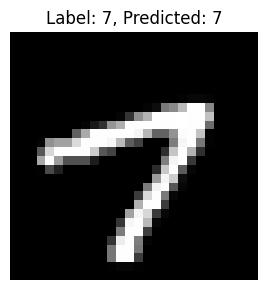

In [10]:
def test_sample(network, sample_idx=101):
    # Prepare sample
    X = np.asarray(train_dataset[sample_idx][0]).flatten() / 255.0
    true_label = train_dataset[sample_idx][1]

    # Get prediction
    prediction = network.forward(X)
    probabilities = softmax(prediction)
    predicted_label = np.argmax(probabilities)

    print(f"True label: {true_label}")
    print(f"Predicted probabilities: {probabilities[0]}")
    print(f"Predicted label: {predicted_label}")

    # Show image
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(train_dataset[sample_idx][0], cmap='gray')
    ax.set_title(f"Label: {true_label}, Predicted: {predicted_label}")
    ax.axis('off')
    fig.tight_layout()
    plt.show()

test_sample(neural_network)

# Aufgabe 4

## Modelle laufen lassen

In [13]:
# Define combinations of learning rates and hidden layer sizes
learning_rates = [0.01, 0.1, 0.5, 1.0]
hidden_sizes = [4, 8, 16]

results = {}

for lr in learning_rates:
    for size in hidden_sizes:
        print(f"Training with learning rate: {lr}, hidden layer size: {size}")

        # Define network layers
        layers = [
            LinearLayer(28 * 28, size, learning_rate=lr),   # Input und Hidden Layer
            LinearLayer(size, 10, learning_rate=lr)         # Hidden und Output Layer
        ]

        activations = [ReLU(), None]

        # Initialize the neural network
        network = NeuralNetwork(layers=layers, activation_functions=activations)

        # Train the network
        train_losses = train_network(network, train_dataset, num_epochs=10)

        # Test the network
        test_loss, test_accuracy = test_network(network, test_dataset)

        # Store results
        results[(lr, size)] = {
            'train_losses': train_losses,
            'test_loss': test_loss,
            'test_accuracy': test_accuracy
        }

Training with learning rate: 0.01, hidden layer size: 4
Epoch 1/10, Avg Loss: 2.3150, LR: 0.050000
Epoch 2/10, Avg Loss: 2.2944, LR: 0.047619
Epoch 3/10, Avg Loss: 2.2814, LR: 0.045455
Epoch 4/10, Avg Loss: 2.2694, LR: 0.043478
Epoch 5/10, Avg Loss: 2.2567, LR: 0.041667
Epoch 6/10, Avg Loss: 2.2428, LR: 0.040000
Epoch 7/10, Avg Loss: 2.2279, LR: 0.038462
Epoch 8/10, Avg Loss: 2.2123, LR: 0.037037
Epoch 9/10, Avg Loss: 2.1966, LR: 0.035714
Epoch 10/10, Avg Loss: 2.1815, LR: 0.034483
Test Loss: 2.1813, Accuracy: 0.2400
Training with learning rate: 0.01, hidden layer size: 8
Epoch 1/10, Avg Loss: 2.3222, LR: 0.050000
Epoch 2/10, Avg Loss: 2.2752, LR: 0.047619
Epoch 3/10, Avg Loss: 2.2447, LR: 0.045455
Epoch 4/10, Avg Loss: 2.2175, LR: 0.043478
Epoch 5/10, Avg Loss: 2.1907, LR: 0.041667
Epoch 6/10, Avg Loss: 2.1630, LR: 0.040000
Epoch 7/10, Avg Loss: 2.1339, LR: 0.038462
Epoch 8/10, Avg Loss: 2.1035, LR: 0.037037
Epoch 9/10, Avg Loss: 2.0727, LR: 0.035714
Epoch 10/10, Avg Loss: 2.0421, LR:

## Visualisierung

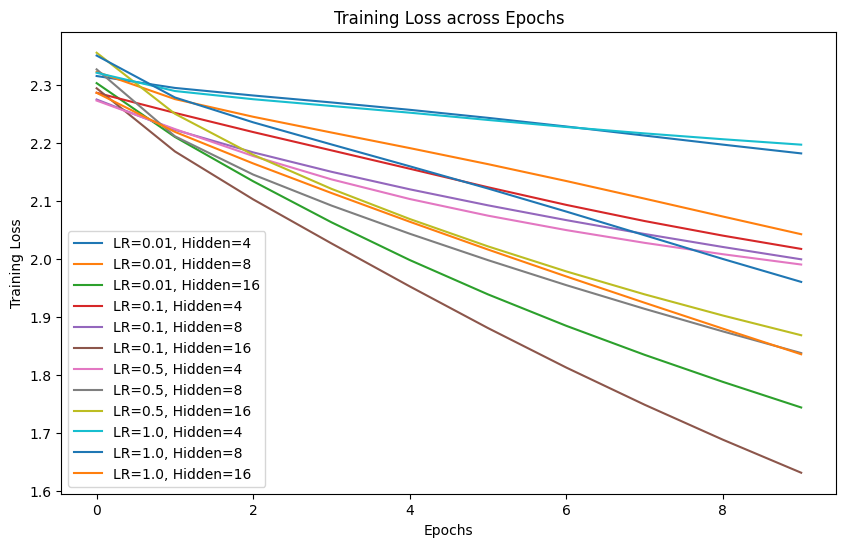

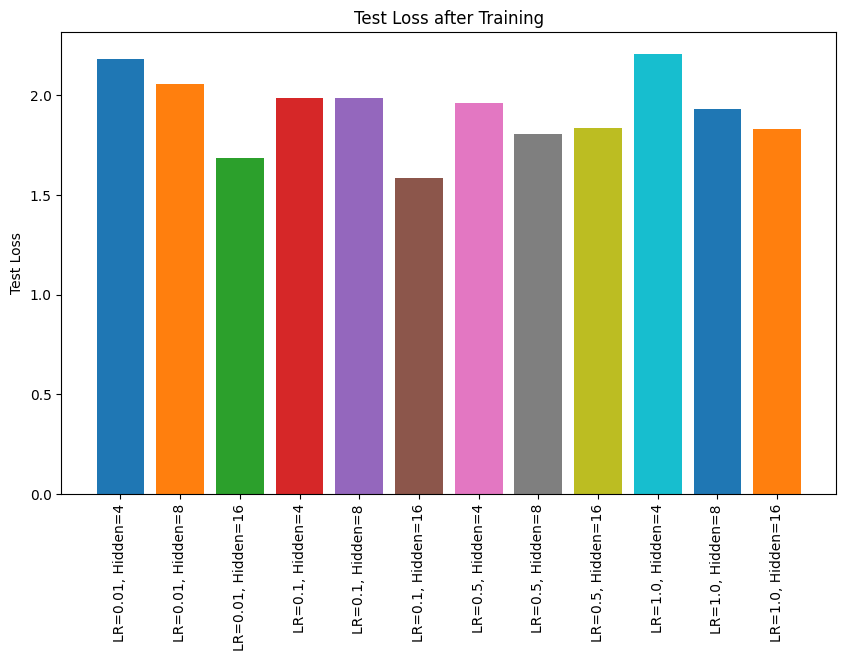

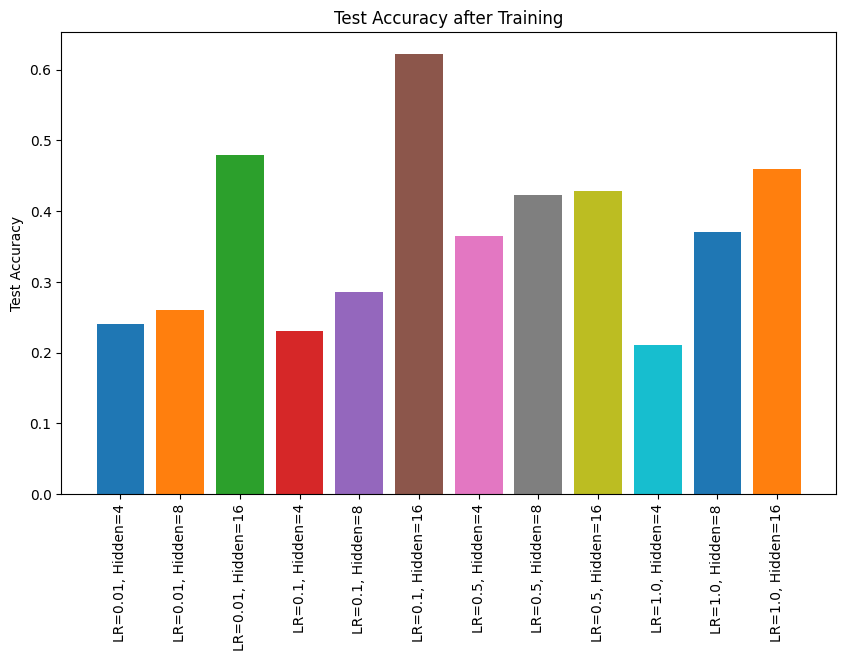

In [14]:


# Training Loss über Epochen
plt.figure(figsize=(10, 6))
for key, value in results.items():
    plt.plot(value['train_losses'], label=f"LR={key[0]}, Hidden={key[1]}")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss across Epochs")
plt.legend()
plt.show()

# Test Loss als Bar Chart
plt.figure(figsize=(10, 6))
for key, value in results.items():
    plt.bar(f"LR={key[0]}, Hidden={key[1]}", value['test_loss'])
plt.ylabel("Test Loss")
plt.title("Test Loss after Training")
plt.xticks(rotation=90)
plt.show()

# Test Accuracy als Bar Chart
plt.figure(figsize=(10, 6))
for key, value in results.items():
    plt.bar(f"LR={key[0]}, Hidden={key[1]}", value['test_accuracy'])
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy after Training")
plt.xticks(rotation=90)
plt.show()

# Aufgabe 5

Training with learning rate: 0.001, hidden layer size: 16
Epoch 1/10, Avg Loss: 2.3138, LR: 0.001000
Epoch 2/10, Avg Loss: 2.3134, LR: 0.000952
Epoch 3/10, Avg Loss: 2.3130, LR: 0.000909
Epoch 4/10, Avg Loss: 2.3126, LR: 0.000870
Epoch 5/10, Avg Loss: 2.3122, LR: 0.000833
Epoch 6/10, Avg Loss: 2.3119, LR: 0.000800
Epoch 7/10, Avg Loss: 2.3116, LR: 0.000769
Epoch 8/10, Avg Loss: 2.3112, LR: 0.000741
Epoch 9/10, Avg Loss: 2.3109, LR: 0.000714
Epoch 10/10, Avg Loss: 2.3107, LR: 0.000690
Test Loss: 2.3077, Accuracy: 0.1180
Training with learning rate: 0.001, hidden layer size: 32
Epoch 1/10, Avg Loss: 2.3257, LR: 0.001000
Epoch 2/10, Avg Loss: 2.3252, LR: 0.000952
Epoch 3/10, Avg Loss: 2.3247, LR: 0.000909
Epoch 4/10, Avg Loss: 2.3242, LR: 0.000870
Epoch 5/10, Avg Loss: 2.3238, LR: 0.000833
Epoch 6/10, Avg Loss: 2.3234, LR: 0.000800
Epoch 7/10, Avg Loss: 2.3229, LR: 0.000769
Epoch 8/10, Avg Loss: 2.3226, LR: 0.000741
Epoch 9/10, Avg Loss: 2.3222, LR: 0.000714
Epoch 10/10, Avg Loss: 2.3218,

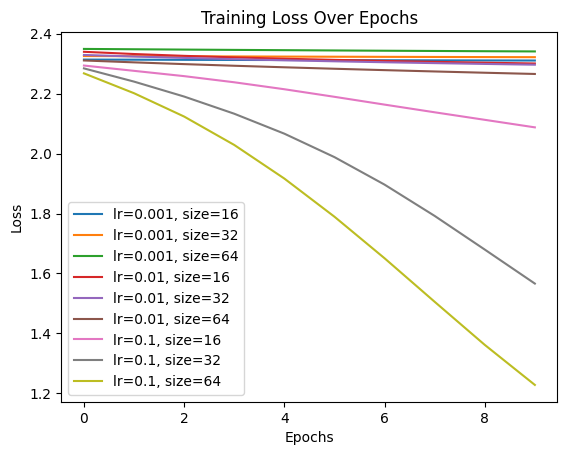

In [15]:

def train_and_evaluate(learning_rates, hidden_sizes, num_epochs=10, batch_size=128):
    results = {}

    for lr in learning_rates:
        for size in hidden_sizes:
            print(f"Training with learning rate: {lr}, hidden layer size: {size}")

            # network layers + hidden layers
            layers = [
                LinearLayer(28 * 28, size, learning_rate=lr),
                LinearLayer(size, size, learning_rate=lr),
                LinearLayer(size, size, learning_rate=lr),
                LinearLayer(size, 10, learning_rate=lr)
            ]

            activations = [ReLU(), ReLU(), ReLU(), None]

            # Initialize the neural network
            network = NeuralNetwork(layers=layers, activation_functions=activations)

            # Train the network
            train_losses = train_network(network, train_dataset, num_epochs=num_epochs, batch_size=batch_size, initial_lr=lr)

            # Test the network
            test_loss, test_accuracy = test_network(network, test_dataset)

            # Store results
            results[(lr, size)] = {
                'train_losses': train_losses,
                'test_loss': test_loss,
                'test_accuracy': test_accuracy
            }
    return results

# learning rates and hidden layer sizes
learning_rates = [0.001, 0.01, 0.1]
hidden_sizes = [16, 32, 64]

# Train and evaluate models
results = train_and_evaluate(learning_rates, hidden_sizes, num_epochs=10)

# Plot training losses
for (lr, size), res in results.items():
    plt.plot(res['train_losses'], label=f"lr={lr}, size={size}")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss Over Epochs")
plt.show()


In [16]:
import pandas as pd

# Nach dem Training: Konvertiere results in DataFrame
df = pd.DataFrame(
    [(lr, size, res['test_accuracy'], res['test_loss']) for (lr, size), res in results.items()],
    columns=['Learning Rate', 'Hidden Layer Size', 'Test Accuracy', 'Test Loss']
)

# Sortieren nach Test Accuracy (absteigend)
df_sorted = df.sort_values(by='Test Accuracy', ascending=False)

# Print Output
print("Sorted Results (Best to Worst):")
print(df_sorted.to_string(index=False))


Sorted Results (Best to Worst):
 Learning Rate  Hidden Layer Size  Test Accuracy  Test Loss
         0.100                 64          0.748   1.130252
         0.100                 32          0.542   1.508657
         0.100                 16          0.292   2.089158
         0.010                 64          0.166   2.261721
         0.010                 16          0.150   2.303083
         0.001                 16          0.118   2.307733
         0.010                 32          0.096   2.297849
         0.001                 64          0.084   2.343763
         0.001                 32          0.082   2.321265
